# Coefficients and Stats

## CURRENT STATUS:

### Stuck on ROC curve for each model, combined

1. Add section for seeing which ones are being classified wrong.
2. Lemmatizing
3. Bootstrapping

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# ==================== CONSTANTS ==================== #
seed = 7
np.random.seed(seed)

# list to get data for
subreddit_list = ["deeplearning", "tensorflow", "scikit_learn", "pandas", "bigdata", "aws", "awscertifications", "css", "html", "javascript", "shittyprogramming", "java", "sql", "learnsql", "postgresql", "softwarearchitecture"]



In [3]:
!pwd

/Users/chris/github/reddit_nlp


In [43]:
from util import databases
from util import dataloader
from util import grid_models
from util.grid_models import custom_stop_words
from util.reddit_functions import Reddit, Visualizer, Labeler
from util.reddit_functions import plot_confusion_matrix


In [5]:
!pwd

/Users/chris/github/reddit_nlp/util


In [6]:
# load data using dataloader module
df = dataloader.data_selector(subreddit_list, source='sqlite')

# what we expected?
avg_posts = []
for sub in subreddit_list:
    posts_length = len(df[df['subreddit'] == sub])
    print(sub, posts_length)
    avg_posts.append(posts_length)
    
print(f'Average post length: {np.mean(avg_posts)}')

df.info()
df.sample(10)

Connection to SQLite DB successful
deeplearning 11463
tensorflow 11589
scikit_learn 1170
pandas 1950
bigdata 6647
aws 11975
awscertifications 11627
css 10955
html 11621
javascript 11032
shittyprogramming 11877
java 9776
sql 11653
learnsql 11433
postgresql 11890
softwarearchitecture 10809
Average post length: 9841.6875
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157467 entries, 0 to 157466
Data columns (total 3 columns):
title        157467 non-null object
subreddit    157467 non-null object
date         157467 non-null object
dtypes: object(3)
memory usage: 3.6+ MB


,title,subreddit,date
65830,How do Deep Auto-regressive models (like text ...,deeplearning,2020-04-21
61295,Reflecting on how far we've come in Valhalla,java,2020-04-20
74627,A Beginner's Guide to Java Agents,java,2020-04-21
154037,[MSSQL] Pivot Question,sql,2020-04-28
19012,Browser support question.,html,2020-04-02
74685,Guide to the Remnants of the Precursors Alpha ...,java,2020-04-21
14237,This Week in AI – Issue #7 | Rubik's Code,tensorflow,2020-04-02
66910,Multiple GPU Training : Why assigning variable...,tensorflow,2020-04-21
135848,Is the AWS Cloud practitioner certificate good...,awscertifications,2020-04-27
39143,[Help]Software Architecture Documenting for ho...,softwarearchitecture,2020-04-10


In [7]:
X = df['title']
y = df['subreddit']

In [8]:
# lemmatizer? for scientist vs scientists

In [9]:
tfidf = TfidfVectorizer(max_df=0.7, max_features=6000, ngram_range=(1,2), stop_words=custom_stop_words)
labeler = Labeler()
model = LogisticRegression(max_iter=1000, multi_class='ovr')
# pipe = Pipeline([('tfidf', tfidf),('logreg', logreg)])

In [ ]:
# bootstrapping?

In [ ]:
pop = np.random.randint(0,500 , size=1000)
sample = np.random.choice(pop, size=300) #so n=300

In [ ]:
sample_mean = []
for _ in range(10000):  #so B=10000
    sample_n = np.random.choice(sample, size=300)
    sample_mean.append(sample_n.mean())

In [ ]:
np.mean(sample_mean)

pop.mean()

sample.mean()

In [10]:
X = tfidf.fit_transform(X)
labeler.fit(y)
y = labeler.transform(y)
classes = labeler.classes_
labeler.encodings_

{'deeplearning': 0,
 'tensorflow': 1,
 'scikit_learn': 2,
 'pandas': 3,
 'bigdata': 4,
 'aws': 5,
 'awscertifications': 6,
 'css': 7,
 'html': 8,
 'javascript': 9,
 'shittyprogramming': 10,
 'java': 11,
 'sql': 12,
 'learnsql': 13,
 'postgresql': 14,
 'softwarearchitecture': 15}

In [11]:
model.fit(X, y)
cross_val_score(model, X, y, cv=StratifiedKFold(shuffle=True, random_state=seed), n_jobs=-1)

array([0.88826443, 0.8877564 , 0.88387896, 0.88807036, 0.8864192 ])

# Coefficients

In [ ]:
if hasattr(model, 'coef_'):
    coef_dict = {}
    for i, sub in enumerate(classes):
        coef_dict[sub] = pd.DataFrame(
                            data=model.coef_[i],
                            index=tfidf.get_feature_names()
                            )
else:
    print('Model does not have coefficients')

In [ ]:
for sub, coef_df in coef_dict.items():

    plt.figure(figsize=(16, 12))
    plt.style.use('seaborn-poster')

    top_10 = coef_df.sort_values(0, ascending=False)[0].head(10)
    bottom_10 = coef_df.sort_values(0, ascending=False)[0].tail(10)
    top_and_bottom = pd.DataFrame(data=top_10.append(bottom_10))
    sns.barplot(x=top_and_bottom[0], y=top_and_bottom.index, palette='Blues_d');

    plt.title(f'Feature Importance for {sub.upper()}', fontsize=20)
    plt.xlabel('Coefficients', fontsize=18)

# Predictions

In [12]:
y_pred = model.predict(X)

In [13]:
y_pred

array([ 0,  0,  0, ..., 15, 15, 15])

In [14]:
y_probs = model.predict_proba(X)

In [15]:
y_probs

array([[4.91838385e-01, 8.62937589e-02, 3.25048091e-03, ...,
        2.02047063e-02, 2.21272799e-02, 2.01017611e-02],
       [4.24642595e-01, 1.36012500e-02, 3.79510890e-01, ...,
        1.51948308e-02, 1.60810452e-02, 1.19861257e-02],
       [7.95247649e-01, 1.39944250e-02, 6.60874510e-03, ...,
        2.44789707e-03, 1.76480560e-03, 5.81987331e-03],
       ...,
       [3.32147935e-03, 6.74615234e-03, 2.04068282e-03, ...,
        4.24974096e-03, 8.34697213e-03, 7.32682507e-01],
       [1.46478810e-02, 4.67773859e-03, 1.21222235e-02, ...,
        2.59693933e-03, 4.11043767e-03, 8.79455896e-01],
       [2.11402608e-03, 8.63955733e-03, 1.19115864e-03, ...,
        8.45467532e-04, 2.89064223e-03, 7.36915481e-01]])

In [ ]:
mcm = multilabel_confusion_matrix(y, y_pred)
mtn = mcm[:, 0, 0]
mtp = mcm[:, 1, 1]
mfn = mcm[:, 1, 0]
mfp = mcm[:, 0, 1]

fig, ax = plt.subplots(ncols=2, nrows=len(classes),
                       figsize=(12, 6*len(classes)))

for i, cm in enumerate(mcm):
    df_cm = pd.DataFrame(cm)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, annot=True, fmt="d", cbar=False,
                cmap='Purples', ax=ax[i, 0])

    ax[i, 0].set_yticklabels(labels=['F', 'T'], rotation='horizontal')
    ax[i, 0].set_xticklabels(labels=['F', 'T'])
    ax[i, 0].xaxis.tick_top()
    ax[i, 0].xaxis.set_label_position('top')
    ax[i, 0].set_title(classes[i].upper())

    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    specificity = tn / (tn + fp)
    recall = tp / (tp + fn)
    fscore = (2 * recall * precision) / (recall + precision)
    
    box_text = f'''
                Subreddit: {classes[i].upper()}\n
                Type 1 Errors (FP): {round(fp,4)}\n
                Type 2 Errors (FN): {round(fn,4)}\n
                Precision: {round(precision, 4)}\n
                Recall / Sensitivity: {round(recall,4)}\n
                Specificity: {round(specificity,4)}\n
                F-Score: {round(fscore,4)}
                '''
    ax[i, 1].text(0.1, 0.5,
                  box_text,
                  bbox=dict(
                            boxstyle="round",
                            ec=('k'),
                            lw=3,
                            fc=(.9,.9,.9),
                           ),
                  horizontalalignment='left',
                  verticalalignment='center',
                  fontsize=20)
    ax[i, 1].set_axis_off()

plt.tight_layout()

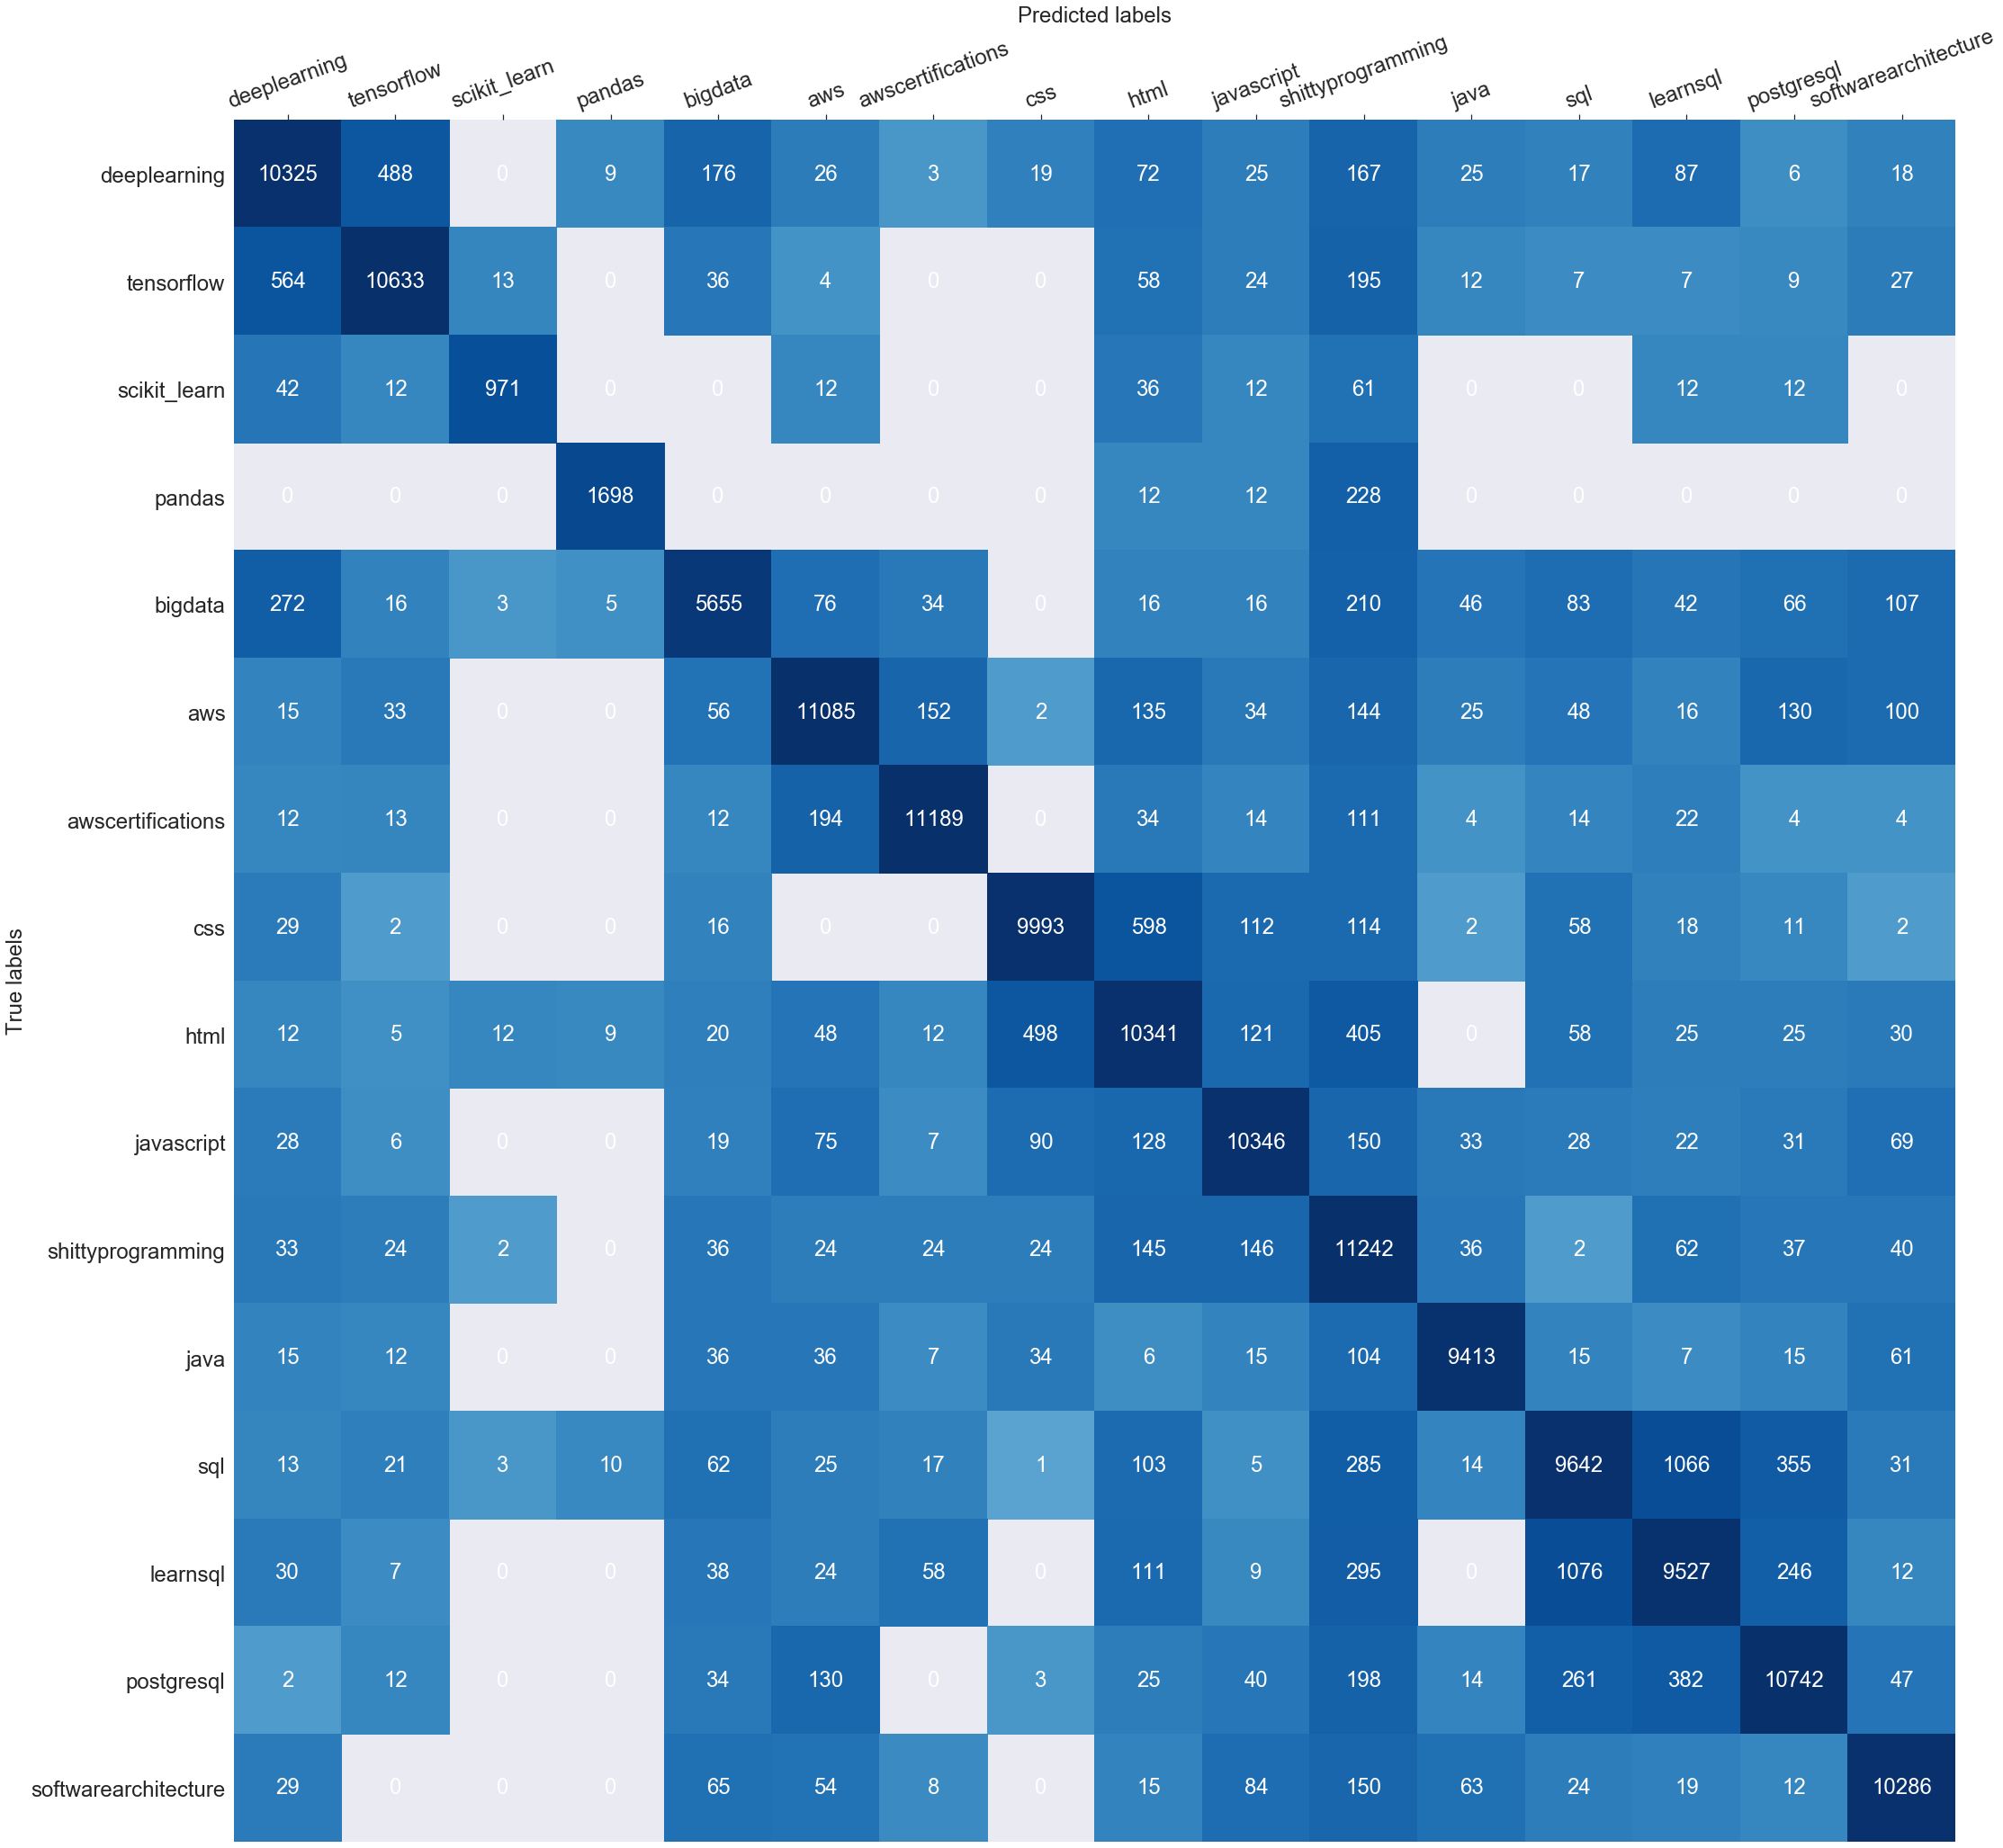

In [46]:
plot_confusion_matrix(model=model, y_true=y, y_pred=y_pred, classes=labeler.classes_)

In [ ]:
y_probs

In [ ]:
print(classification_report(y, y_pred, digits=3, target_names=classes))

## Which ones are we missing?

In [ ]:
aws_probs = y_probs[:, 0]

In [ ]:
y

In [ ]:
roc_auc_score(y, y_probs[:, 1])

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
plot_roc_curve(fpr, tpr)

<h1>TODO:</h1>

1. Make it have the roc for each sub, have to get into the original df where subname equals indexes?

In [ ]:
probs_df = pd.DataFrame(data=y_probs, columns=classes)
probs_df['predicted'] = labeler.inverse_transform(y_pred)
probs_df['actual'] = df['subreddit']
probs_df.head(10)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, label in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
for label in probs_df:
    # only probs for this label
    probs_y = probs_df[label]
    # get the index from df
    label_index = df.index[df['subreddit'] == label].tolist()
    # get matching y values
    true_y = y[label_index]
    print(roc_auc_score(y, probs_y, multi_class='ovr'))

In [ ]:
auc = roc_auc_score(y, y_probs, multi_class='ovr')
auc

In [ ]:
# not multiclass
fpr, tpr, thresholds = roc_curve(y, y_probs[:,1])

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc})', color='r', marker='D')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve', size=20)
plt.legend(fontsize=14);

In [ ]:
x1 = np.random.normal(0, 0.8, 1000)
x2 = np.random.normal(-2, 1, 1000)
x3 = np.random.normal(3, 2, 1000)
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)
plt.hist(x1, **kwargs) 
plt.hist(x2, **kwargs) 
plt.hist(x3, **kwargs);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(y_probs, bins=25)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
hst0 = plt.hist(y_probs[y == 0],
         bins=25,
#          color='b',
         alpha = 0.6,
         label='Technology',)

hst1 = plt.hist(y_probs[y == 1],
         bins=25,
#          color='orange',
         alpha = 0.6,
         label='Science')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = max(hst1[0].max(), hst0[0].max()), # Max of the two highest respective hist values
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Science)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# Thanks to Matt Brems for the colorful graphs! :)